In [1]:
from PIL import Image
import numpy as np
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

datafolder = os.path.join("Data","Versuch_Kugel")
#imagefolder = "Bilder_2"
imagefolder = "Bilder"
imagefolder = os.path.join(datafolder,imagefolder)
r = "rot.txt"
g = "grün.txt"
b = "blau.txt"

# in m
Pixelgroesse = 4.5e-6
#Pixelfläche in m²
A = Pixelgroesse **2

N = 1600
M = 1200

Bilder einlesen und in schwarz, weiß und offsetbild aufteilen

In [2]:
def get_imgs(folder,endswith = "*.png",pattern=""):
    return glob.glob(os.path.join(folder,pattern+endswith))


weiss = get_imgs(imagefolder,pattern="*Hell")
schwarz = get_imgs(imagefolder,pattern="*Dunkel")
offset = get_imgs(imagefolder,pattern="*Offset")

print("Anzahl Bilder : \n\n weiß: {}\tschwarz: {}\toffset: {}".format(len(weiss),len(schwarz),len(offset)))

Anzahl Bilder : 

 weiß: 26	schwarz: 26	offset: 1


Bildernamen nach ihrere Belichtungszeit ordnen/zuweisen (sowie Nr)

In [3]:
regex = r"T_[0-9]?_([0-9]+)_Nr([0-9]+).png"
def get_T_NR(img_path):
    matches = re.search(regex, img_path, re.DOTALL)
    if matches:
        T = int(matches[1])
        NR = int(matches[2])
        return T,NR
    print("INCONSISTENT NAMING: ",img_path)
    return None,None
        
#Images NR1
img_weiss_1 = []
img_schwarz_1 = []

#Images NR2
img_schwarz_2 = []
img_weiss_2 = []

Bilder = {1:{'w':img_weiss_1,
             's':img_schwarz_1},
          2:{'w':img_weiss_2,
             's':img_schwarz_2}}

for w,s in zip(weiss,schwarz):
        T,NR = get_T_NR(w)
        Bilder[NR]['w'].append((w,T))
        T,NR = get_T_NR(s)
        if T is None:
            continue
        Bilder[NR]['s'].append((s,T))
        
img_weiss_1 = sorted(img_weiss_1, key=lambda x: x[1])
img_weiss_2 = sorted(img_weiss_2, key=lambda x: x[1])
img_schwarz_1 = sorted(img_schwarz_1, key=lambda x: x[1])
img_schwarz_2 = sorted(img_schwarz_2, key=lambda x: x[1])
print(len(img_weiss_1))
print(len(img_weiss_2))
print(len(img_schwarz_1))
print(len(img_schwarz_2))
Belichtungszeit = [i[1] for i in img_weiss_1]
Belichtungszeit = np.array(Belichtungszeit)
print(Belichtungszeit)

13
13
13
13
[ 2  7 12 17 22 27 32 37 42 47 52 57 62]


Textdatein des Spektrometers einlesen

In [4]:
def genfromtxt(path,skip = 13):
    csv = []
    with open(path,'r') as f:
        line = f.readline()
        cnt = 1
        while cnt < skip:
            line = f.readline()
            cnt += 1
        while line:
            line = f.readline()
            if "\t" in line:
                x,y = line.split("\t")
            else:
                line = f.readline()
                continue
            x = float(x.replace(",","."))
            y = float(y.replace(",","."))
            csv.append( [x,y] )
            cnt +=1
            
    return np.array(csv)


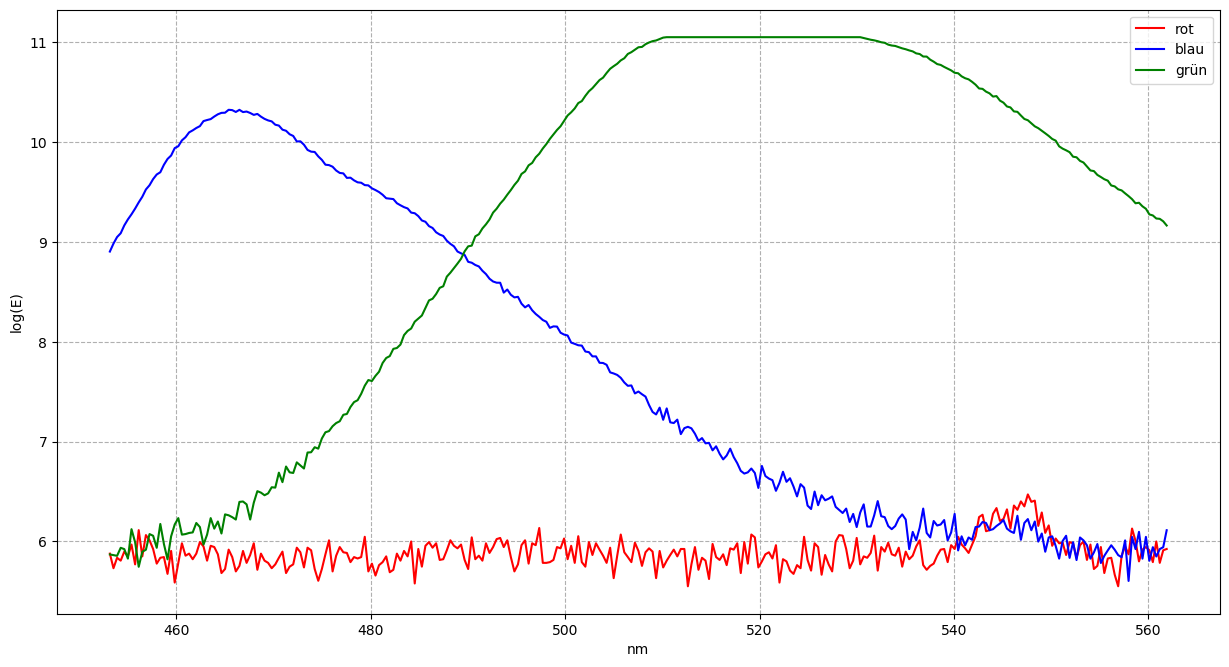

In [5]:
red   = genfromtxt(os.path.join(datafolder,r))
green = genfromtxt(os.path.join(datafolder,g))
blue  = genfromtxt(os.path.join(datafolder,b))

plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.plot(red[300:600,0],np.log(red[300:600,1]),color='red',label="rot")
plt.plot(blue[300:600,0],np.log(blue[300:600,1]),color='blue',label="blau")
plt.plot(green[300:600,0],np.log(green[300:600,1]),color='green',label="grün")
plt.legend(loc='upper right')
plt.xlabel("nm")
plt.ylabel("log(E)")
plt.grid(linestyle="--")
plt.show()

In [6]:
def mittlerergauwert(img1,img2):
    mw = []
    std = []
    for img1,img2 in zip(img1,img2):
        i1 = np.array(Image.open(img1[0]))
        i2 = np.array(Image.open(img2[0]))
        mw.append((1/(2*N*M)) * ((i1+i2)/2).sum())
        std.append((1/(2*N*M)) * ((i1-i2)**2).sum() )
    return np.array(mw),np.array(std)

        
mg_schwa,zr_schwa = mittlerergauwert(img_schwarz_1,img_schwarz_2)
mg_weiss,zr_weiss = mittlerergauwert(img_weiss_1,img_weiss_2)

def regression(x,y):
    slope, intercept, r_value, p_value, std_err= stats.linregress(x,y)
    return slope,intercept


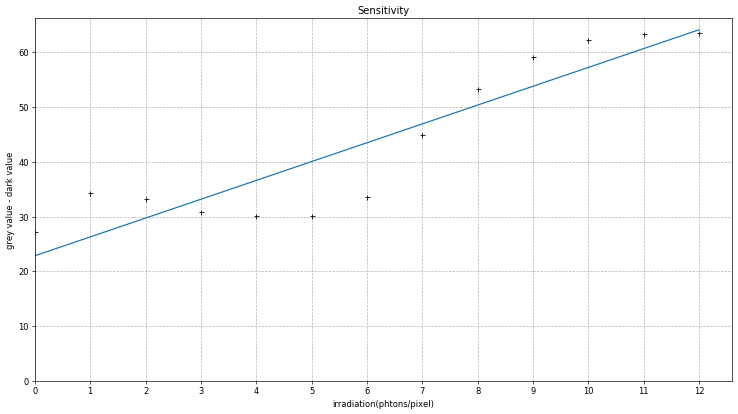

In [7]:
x = np.arange(len(mg_schwa))
a,b = regression(x,mg_weiss-mg_schwa)

plt.figure(figsize=(15,8),dpi=60,facecolor='w', edgecolor='k')
plt.plot(x,b+a*x)
plt.plot(x,mg_weiss-mg_schwa,'+',color='black')
plt.xticks(x)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.ylabel("grey value - dark value")
plt.xlabel("irradiation(phtons/pixel)")
plt.title("Sensitivity")
plt.grid(linestyle="--")
plt.show()

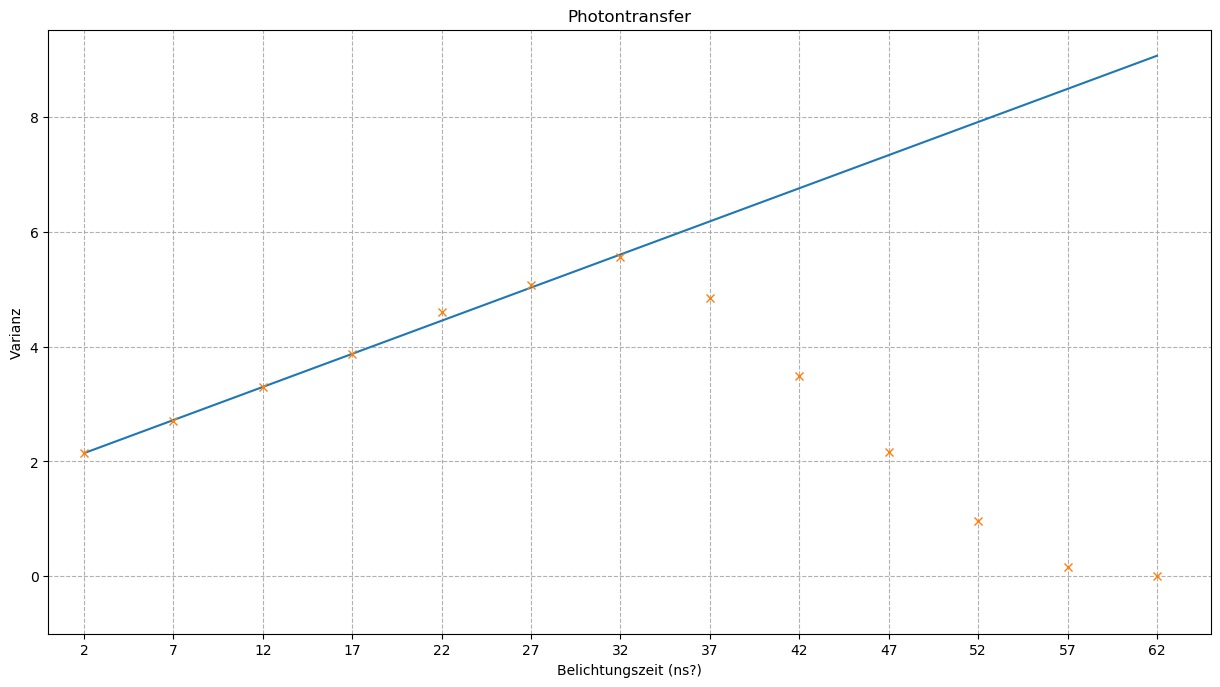

Sättigungspunkt: 5.550752604166667
K              : 0.5767003645833334


In [33]:
diff = zr_weiss-zr_schwa
Saettigungspunkt = diff.max()

i = np.where(diff == Saettigungspunkt)
i = np.where(diff[:int(i[0]) ] <= 0.7 * Saettigungspunkt)

a,b = regression(np.arange(len(i[0])),diff[i])

plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.plot(Belichtungszeit,b+a*x)
plt.plot(Belichtungszeit,zr_weiss-zr_schwa,'x')
plt.ylim(ymin=-1)
plt.xlim(xmin=0)
plt.xticks(Belichtungszeit)
plt.ylabel("Varianz")
plt.xlabel("Belichtungszeit (ns?)")
plt.title("Photontransfer")
plt.grid(linestyle="--")
plt.show()

print("Sättigungspunkt:",Saettigungspunkt)
print("K              :",a)

### a) 

Bestimmen Sie den Sättigungspunkt der Kamera, d.h. die maximaleBelichtungszeit, ab der die Pixelvarianz wieder abzunehmen beginnt

Sättigungspunkt bestimmen: 

Maximum des Photonentransfers -jenseits dieses Punktes fällt die Varianz, da die Pixel in Sättigunggehen

Sättigungspunkt bei : $\Rightarrow 5.550752604166667$, 32 ns Belichtungszeit

---

Die Kameraverstärkung K ist laut der zweiten Kameragleichung die Steigung des Photonentransfers. Bestimmung ebenfallsdurch lineare Regression der ersten 70%

K = 0.5767003645833334